In [1]:
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

## Example: Benford's Law

In [4]:
digits = np.arange(1, 10)
benford_model = np.log10(1 + 1/digits)
benford_model

array([0.30103   , 0.17609126, 0.12493874, 0.09691001, 0.07918125,
       0.06694679, 0.05799195, 0.05115252, 0.04575749])

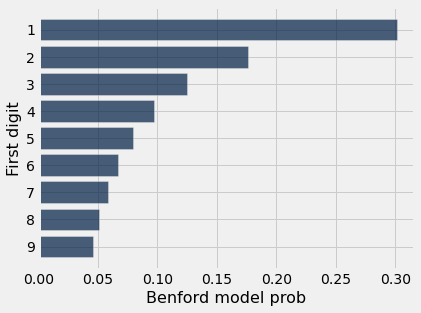

In [5]:
benford = Table().with_columns(
    'First digit', digits,
    'Benford model prob', benford_model)
benford.barh('First digit')

In [6]:
# You don't have to understand how this function works, since it uses Python features from beyond Data 8.
def first_digit(num):
    return int(str(num)[0])

In [7]:
first_digit(32)

3

In [8]:
first_digit(17719087)

1

In [9]:
# County populations from the census data
counties = Table.read_table('data/counties.csv')
counties = counties.where('SUMLEV', 50).select(5,6,9).relabeled(0,'State').relabeled(1,'County').relabeled(2,'Population')
counties.show(3)

State,County,Population
Alabama,Autauga County,54684
Alabama,Baldwin County,183216
Alabama,Barbour County,27336


In [11]:
first_digits = counties.apply(first_digit, 'Population')
counties = counties.with_column('First digit', first_digits)
counties.show()

State,County,Population,First digit
Alabama,Autauga County,54684,5
Alabama,Baldwin County,183216,1
Alabama,Barbour County,27336,2
Alabama,Bibb County,22879,2
Alabama,Blount County,57344,5
Alabama,Bullock County,10886,1
Alabama,Butler County,20945,2
Alabama,Calhoun County,118443,1
Alabama,Chambers County,34111,3
Alabama,Cherokee County,25968,2


In [13]:
num_counties = counties.num_rows
num_counties

3142

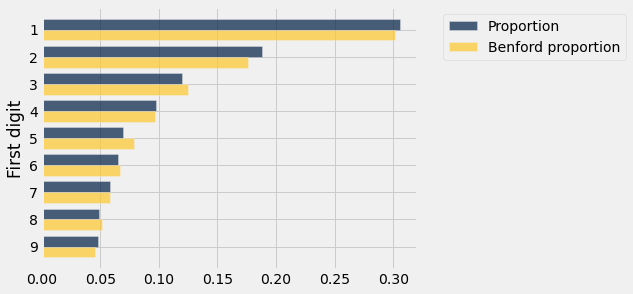

In [14]:
by_digit = counties.group('First digit')
proportions = by_digit.column('count')/num_counties # proportions, extract as an array
by_digit = by_digit.with_columns(
    'Proportion', proportions,
    'Benford proportion', benford_model
)
by_digit.drop('count').barh('First digit')

Null hypothesis:  the match up with  the bendfrd model is NOT due to chance

Alternative hypothesis:  similarities in our counties' proportion and Benford's model are due to chance

Test statistic: TVD

Fill in the blank with "Bigger" or "Smaller":

Large values of the test statistic favor the alternative

In [16]:
observed_tvd = sum(abs(proportions - benford_model))/2
observed_tvd
print(proportions)
print(benford_model)
observed_tvd

[0.30521961 0.18777849 0.11935073 0.09770847 0.06906429 0.06556334
 0.05824316 0.04901337 0.04805856]
[0.30103    0.17609126 0.12493874 0.09691001 0.07918125 0.06694679
 0.05799195 0.05115252 0.04575749]


0.019227569718005835

In [17]:
sample_proportions(num_counties, benford_model)

array([0.30394653, 0.17313813, 0.1145767 , 0.10184596, 0.08243157,
       0.06619987, 0.06078931, 0.05283259, 0.04423934])

In [19]:
help(sample_proportions)

Help on function sample_proportions in module datascience.util:

sample_proportions(sample_size, probabilities)
    Return the proportion of random draws for each outcome in a distribution.
    
    This function is similar to np.random.multinomial, but returns proportions
    instead of counts.
    
    Args:
        ``sample_size``: The size of the sample to draw from the distribution.
    
        ``probabilities``: An array of probabilities that forms a distribution.
    
    Returns:
        An array with the same length as ``probability`` that sums to 1.



In [18]:
simulated_frequencies = sample_proportions(num_counties, benford_model)
tvd = sum(abs(simulated_frequencies - benford_model))/2
tvd

0.020286623112315112

In [20]:
def simulate_county_first_digits():
    simulated_frequencies = sample_proportions(num_counties, benford_model)
    tvd = sum(abs(simulated_frequencies - benford_model))/2
    return tvd

In [21]:
simulated_tvds = make_array()

for i in np.arange(10000):
    simulated_tvds = np.append(simulated_tvds, simulate_county_first_digits())

observed tvd: 0.019227569718005835


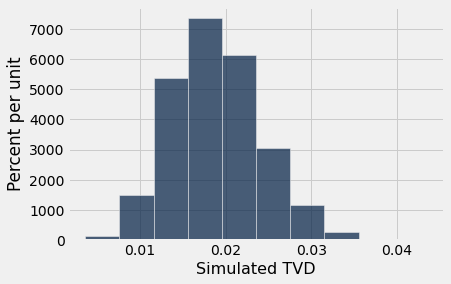

In [24]:
Table().with_column('Simulated TVD', simulated_tvds).hist(0)
print('observed tvd:', observed_tvd)

In [25]:
simulated_tvds >= observed_tvd # direction of the alternative is to the right (bigger values)

array([ True,  True, False, ...,  True, False, False])

In [26]:
np.count_nonzero(simulated_tvds >= observed_tvd)

4537

In [23]:
np.count_nonzero(simulated_tvds >= observed_tvd) / 10000 # we are computing the p-value here

0.4537

Are the data consistent with the null hypothesis?

In [ ]:
# in your own words, answer the question above using the visualization (histogram) and the p-value




## Example: sleep survey

In [29]:
survey = Table.read_table('data/sleep_survey.csv')
survey.group('Sleep position')

Sleep position,count
On your back,302
On your left side,374
On your right side,434
On your stomach,212


In [30]:
def simplify(sleep_position):
    if sleep_position == 'On your left side' or sleep_position == 'On your right side':
        return 'side'
    else:
        return 'back or stomach'
    
survey = survey.with_column(
    'position',
    survey.apply(simplify, 'Sleep position')
).select('position', 'Hours of sleep')

survey

position,Hours of sleep
back or stomach,7
side,7
back or stomach,8
side,8
side,7
back or stomach,8
side,5
side,6
side,7
side,7


In [31]:
survey.group('position', np.average)

position,Hours of sleep average
back or stomach,7.12792
side,7.0328


Null hypothesis:  Any differences between average hours of sleep between back/stomach sleepersor side sleepers is due to chance

Alternative hypothesis:  

Back/stomach sleepers on average get more sleep than side sleepers


Test statistic:

_x_ Average hours of sleep for back/stomach - Average hours of sleep for side 


__ Asolute value of (Average hours of sleepfor back/stomach - Average hours of sleep for side) __





Fill in the blank with "Bigger" or "Smaller":

__ Larger __ values of the test statistic favor the alternative

In [36]:
def compute_test_statistic(tbl):
    grouped = tbl.group('position', np.average)
    avgs = grouped.column('Hours of sleep average')
    return avgs.item(0) - avgs.item(1)

In [34]:
obs_test_stat = compute_test_statistic(survey)
obs_test_stat

0.09512125823477291

In [35]:
random_labels = survey.sample(with_replacement=False).column('position')

In [38]:
def simulate_under_null():
    
    # generate a sample
    random_labels = survey.sample(with_replacement=False).column('position') # an array
    # add it to a table
    relabeled_tbl = survey.with_column('position', random_labels)
    # hint: use compute_test_statistic with our new table
    simulated_stat = compute_test_statistic(relabeled_tbl)
    return simulated_stat


In [46]:
simulate_under_null()

0.009176233771237108

In [48]:
# simulate under null, 1000
# collect simualation results in a way we can view them in a histogram in the cell below
simulated_diff = make_array() # initialize an array, to collect our simiulated stats in our for
# loop

for i in np.arange(1000):
    null_stat = simulate_under_null()
    simulated_diff = np.append(simulated_diff, null_stat)

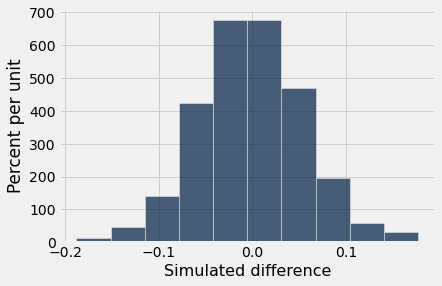

In [50]:
Table().with_column('Simulated difference', simulated_diff).hist(0)

In [51]:
obs_test_stat

0.09512125823477291

In [54]:
np.mean(simulated_diff >= obs_test_stat)

0.047

Are the data consistent with the null hypothesis?